Using phone:Pixel 3 XL
My Info: Pelipper CP 1490
Opponent Info: CP 1499 Graveler
My Pokémon: Pelipper
Moveset: ['WING_ATTACK', 'WEATHER_BALL_WATER', 'HURRICANE']
counts: (2, [[5, 4, 5], [9, 8, 8]])
Opponent Pokémon: Graveler
Moveset: ['MUD_SHOT', 'ROCK_SLIDE', 'ROCK_BLAST']
counts: (2, [[5, 5, 5], [5, 4, 5]])


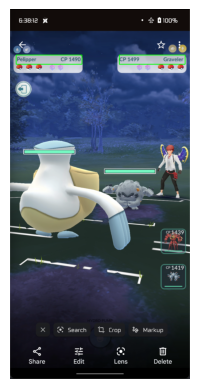

In [65]:
%matplotlib inline

import cv2
import numpy as np
import time
from Quartz import CGWindowListCopyWindowInfo, kCGWindowListOptionOnScreenOnly, kCGWindowListExcludeDesktopElements, kCGNullWindowID
from AppKit import NSScreen
from mss import mss
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
from AppKit import NSWindow, NSTitledWindowMask
import json
from difflib import get_close_matches
import re
import math
# Load the JSON files
with open('pk.json', 'r') as file:
    pokemon_names = json.load(file)

with open('great-league.json', 'r') as file:
    great_league = json.load(file)

with open('moves.json', 'r') as file:
    moves = json.load(file)

# Find the scrcpy window
def find_scrcpy_window(owner_name):
    window_info_list = CGWindowListCopyWindowInfo(kCGWindowListOptionOnScreenOnly | kCGWindowListExcludeDesktopElements, kCGNullWindowID)
    for window_info in window_info_list:
        window_owner_name = window_info.get('kCGWindowName', '')
        for owner in owner_name:
            if owner in window_owner_name:
                print(f'Using phone:{owner}')
                return window_info
    return None

# Capture the scrcpy window
def capture_scrcpy_window(window, title_bar_height):
    x = window['kCGWindowBounds']['X']
    y = window['kCGWindowBounds']['Y']
    width = window['kCGWindowBounds']['Width']
    height = window['kCGWindowBounds']['Height']
    header_height = title_bar_height  # Height of the window header on macOS

    with mss() as sct:
        monitor = {'left': int(x), 'top': int(y) + header_height, 'width': int(width), 'height': int(height) - header_height}
        screenshot = sct.grab(monitor)
        screenshot_np = np.array(screenshot)

    return screenshot_np

def get_title_bar_height():
    window = NSWindow.alloc().initWithContentRect_styleMask_backing_defer_(
        ((0, 0), (100, 100)),
        NSTitledWindowMask,
        2,
        False
    )
    content_height = window.contentView().frame().size.height
    window_height = window.frame().size.height
    title_bar_height = window_height - content_height
    return title_bar_height

def apply_binary_threshold(image, blur_kernel_size=(5, 5)):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, blur_kernel_size, 0)
    
    # Apply binary thresholding
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return thresholded

def segment_image(image, k):
    pixels = image.reshape((-1, 3))
    pixels = np.float32(pixels)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    return segmented_image

def crop_top(image, ratio):
    height, _, _ = image.shape
    cropped_height = int(height * ratio)
    return image[:cropped_height, :, :]

# Function to find the closest Pokémon name
def closest_pokemon_name(name, names_list):
    closest_name = get_close_matches(name, names_list, n=1, cutoff=0.6)
    if closest_name:
        return closest_name[0]
    return None

# Function to get the moveset information for a Pokémon
def get_moveset(pokemon_name, data):
    for pokemon in data:
        if pokemon_name.lower() == pokemon['speciesName'].lower():
            return pokemon['moveset']
    return None

def get_movecounts(moveset,data):
    fast_move = moveset[0]
    charged1 = moveset[1]
    charged2 = moveset[2]
    for move in data:
        if fast_move.lower() == move['moveId'].lower():
            fast_count = round(move['cooldown']/500)
            counts = []
            for move2 in data:
                if charged1.lower() == move2['moveId'].lower():
                    counts.append(calculate_move_counts(move,move2))
            for move2 in data:
                if charged2.lower() == move2['moveId'].lower():
                    counts.append(calculate_move_counts(move,move2))
            return fast_count,counts
    return None

def calculate_move_counts(fast_move, charged_move):
    counts = []

    counts.append( math.ceil( (charged_move['energy'] * 1) / fast_move['energyGain']) )
    counts.append( math.ceil( (charged_move['energy'] * 2) / fast_move['energyGain']) - counts[0] )
    counts.append( math.ceil( (charged_move['energy'] * 3) / fast_move['energyGain']) - counts[0] - counts[1] )

    return counts


phones = ['Pixel 3 XL', 'Pixel 7 Pro']
scrcpy_window = find_scrcpy_window(phones)
title_bar_height = get_title_bar_height()
# Load the template images in color format
my_pokemon_template_color = cv2.imread('templates/my-temp2.png')
opp_pokemon_template_color = cv2.imread('templates/opp-temp2.png')
my_pokemon_template_color = cv2.resize(my_pokemon_template_color, (269, 77))
opp_pokemon_template_color = cv2.resize(opp_pokemon_template_color, (269, 77))
# Convert the template images to grayscale
my_pokemon_template = cv2.cvtColor(my_pokemon_template_color, cv2.COLOR_BGR2GRAY)
opp_pokemon_template = cv2.cvtColor(opp_pokemon_template_color, cv2.COLOR_BGR2GRAY)

if scrcpy_window:
    screen = capture_scrcpy_window(scrcpy_window, title_bar_height)

    my_roi = (23, 175, 250, 35)
    opp_roi = (415, 175, 250, 35)

    my_roi_img = screen[my_roi[1]:my_roi[1] + my_roi[3], my_roi[0]:my_roi[0] + my_roi[2]]
    opp_roi_img = screen[opp_roi[1]:opp_roi[1] + opp_roi[3], opp_roi[0]:opp_roi[0] + opp_roi[2]]

    gray_my_roi = cv2.cvtColor(my_roi_img, cv2.COLOR_BGR2GRAY)
    gray_opp_roi = cv2.cvtColor(opp_roi_img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale images
    blur_my_roi = cv2.GaussianBlur(gray_my_roi, (5, 5), 0)
    blur_opp_roi = cv2.GaussianBlur(gray_opp_roi, (5, 5), 0)

    # Apply binary thresholding
    _, thresh_my_roi = cv2.threshold(blur_my_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, thresh_opp_roi = cv2.threshold(blur_opp_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to remove noise
    kernel = np.ones((2, 2), np.uint8)
    thresh_my_roi = cv2.morphologyEx(thresh_my_roi, cv2.MORPH_OPEN, kernel)
    thresh_opp_roi = cv2.morphologyEx(thresh_opp_roi, cv2.MORPH_OPEN, kernel)

    # Use pytesseract to extract text from the processed images
    my_info = pytesseract.image_to_string(thresh_my_roi, config='--psm 6').strip()
    opp_info = pytesseract.image_to_string(thresh_opp_roi, config='--psm 6').strip()

    # Display the extracted Pokémon name and CP value
    print("My Info:", my_info)
    print("Opponent Info:", opp_info)


    # Extract Pokémon names using regex
    my_info_match = re.search(r'[A-Z][a-z]+', my_info)
    opp_info_match = re.search(r'[A-Z][a-z]+', opp_info)
    # Find and correct the Pokémon names
    corrected_my_name = closest_pokemon_name(my_info, pokemon_names)
    corrected_opp_name = closest_pokemon_name(opp_info, pokemon_names)

    if my_info_match and opp_info_match:
        my_info_name = my_info_match.group(0)
        opp_info_name = opp_info_match.group(0)

        # Find and correct the Pokémon names
        corrected_my_name = closest_pokemon_name(my_info_name, pokemon_names)
        corrected_opp_name = closest_pokemon_name(opp_info_name, pokemon_names)

        if corrected_my_name:
            print(f"My Pokémon: {corrected_my_name}")
            my_moveset = get_moveset(corrected_my_name, great_league)
            fast_count = get_movecounts(my_moveset,moves)
            print(f"Moveset: {my_moveset}")
            print(f"counts: {fast_count}")
        else:
            print(f"Invalid Pokémon name: {my_info_name}")

        if corrected_opp_name:
            print(f"Opponent Pokémon: {corrected_opp_name}")
            opp_moveset = get_moveset(corrected_opp_name, great_league)
            fast_count = get_movecounts(opp_moveset,moves)
            print(f"Moveset: {opp_moveset}")
            print(f"counts: {fast_count}")
        else:
            print(f"Invalid Pokémon name: {opp_info_name}")

    else:
        print("Could not extract Pokémon names from the OCR output.")

    # Draw rectangles around the ROIs on the screen
    roi_color = (0, 255, 0)  # Color for the rectangle (green in this case)
    screen_with_rois = cv2.rectangle(screen.copy(), (my_roi[0], my_roi[1]), (my_roi[0] + my_roi[2], my_roi[1] + my_roi[3]), roi_color, 2)
    screen_with_rois = cv2.rectangle(screen_with_rois, (opp_roi[0], opp_roi[1]), (opp_roi[0] + opp_roi[2], opp_roi[1] + opp_roi[3]), roi_color, 2)

    plt.imshow(cv2.cvtColor(screen_with_rois, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.show()
else:
    print('scrcpy window not found.')



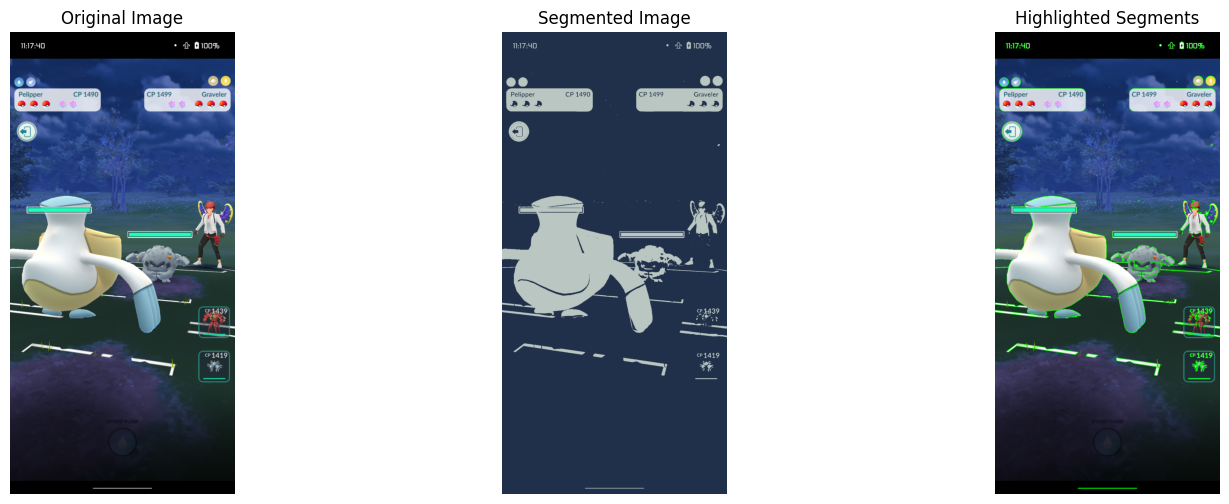

In [12]:
# %matplotlib inline

# import cv2
# import numpy as np
# import time
# from Quartz import CGWindowListCopyWindowInfo, kCGWindowListOptionOnScreenOnly, kCGWindowListExcludeDesktopElements, kCGNullWindowID
# from AppKit import NSScreen
# from mss import mss
# import matplotlib.pyplot as plt
# import pytesseract
# from PIL import Image
# from AppKit import NSWindow, NSTitledWindowMask

# # Find the scrcpy window
# def find_scrcpy_window(owner_name):
#     window_info_list = CGWindowListCopyWindowInfo(kCGWindowListOptionOnScreenOnly | kCGWindowListExcludeDesktopElements, kCGNullWindowID)
#     for window_info in window_info_list:
#         window_owner_name = window_info.get('kCGWindowName', '')
#         for owner in owner_name:
#             if owner in window_owner_name:
#                 print(f'Using phone:{owner}')
#                 return window_info
#     return None

# # Capture the scrcpy window
# def capture_scrcpy_window(window, title_bar_height):
#     x = window['kCGWindowBounds']['X']
#     y = window['kCGWindowBounds']['Y']
#     width = window['kCGWindowBounds']['Width']
#     height = window['kCGWindowBounds']['Height']
#     header_height = title_bar_height  # Height of the window header on macOS

#     with mss() as sct:
#         monitor = {'left': int(x), 'top': int(y) + header_height, 'width': int(width), 'height': int(height) - header_height}
#         screenshot = sct.grab(monitor)
#         screenshot_np = np.array(screenshot)

#     return screenshot_np

# def get_title_bar_height():
#     window = NSWindow.alloc().initWithContentRect_styleMask_backing_defer_(
#         ((0, 0), (100, 100)),
#         NSTitledWindowMask,
#         2,
#         False
#     )
#     content_height = window.contentView().frame().size.height
#     window_height = window.frame().size.height
#     title_bar_height = window_height - content_height
#     return title_bar_height

# def apply_binary_threshold(image, blur_kernel_size=(5, 5)):
#     # Convert the image to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
#     # Apply Gaussian blur
#     blurred = cv2.GaussianBlur(gray, blur_kernel_size, 0)
    
#     # Apply binary thresholding
#     _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
#     return thresholded

# def segment_image(image, k):
#     pixels = image.reshape((-1, 3))
#     pixels = np.float32(pixels)
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
#     _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
#     centers = np.uint8(centers)
#     segmented_image = centers[labels.flatten()]
#     segmented_image = segmented_image.reshape(image.shape)
#     return segmented_image

# def crop_top(image, ratio):
#     height, _, _ = image.shape
#     cropped_height = int(height * ratio)
#     return image[:cropped_height, :, :]

# phones = ['Pixel 3 XL', 'Pixel 7 Pro']
# scrcpy_window = find_scrcpy_window(phones)
# title_bar_height = get_title_bar_height()
# # Load the template images in color format
# my_pokemon_template_color = cv2.imread('templates/my-temp2.png')
# opp_pokemon_template_color = cv2.imread('templates/opp-temp2.png')
# my_pokemon_template_color = cv2.resize(my_pokemon_template_color, (269, 77))
# opp_pokemon_template_color = cv2.resize(opp_pokemon_template_color, (269, 77))
# # Convert the template images to grayscale
# my_pokemon_template = cv2.cvtColor(my_pokemon_template_color, cv2.COLOR_BGR2GRAY)
# opp_pokemon_template = cv2.cvtColor(opp_pokemon_template_color, cv2.COLOR_BGR2GRAY)

# if scrcpy_window:
#     screen = capture_scrcpy_window(scrcpy_window, title_bar_height)

#     # Segment the screenshot image with k=2
#     segmented_screen = segment_image(screen, k=2)

#     # Crop the top 30% of the segmented image
#     cropped_segmented_screen = crop_top(segmented_screen, ratio=0.3)

#     gray_cropped_segmented_screen = cv2.cvtColor(cropped_segmented_screen, cv2.COLOR_BGR2GRAY)

#     # Use template matching on the cropped segmented image
#     my_pokemon_result = cv2.matchTemplate(gray_cropped_segmented_screen, my_pokemon_template, cv2.TM_CCOEFF_NORMED)
#     opp_pokemon_result = cv2.matchTemplate(gray_cropped_segmented_screen, opp_pokemon_template, cv2.TM_CCOEFF_NORMED)

#     # Set a threshold value for the match (e.g., 0.7 for 70% similarity)
#     threshold = 0.3

#     # Find the location of the matched templates
#     my_pokemon_loc = np.where(my_pokemon_result >= threshold)
#     opp_pokemon_loc = np.where(opp_pokemon_result >= threshold)

#     if my_pokemon_loc[0].size > 0 and opp_pokemon_loc[0].size > 0:
#         # Get the top-left corner coordinates of the matched templates
#         my_pokemon_pt = (my_pokemon_loc[1][0], my_pokemon_loc[0][0])
#         opp_pokemon_pt = (opp_pokemon_loc[1][0], opp_pokemon_loc[0][0])

#         # Define the ROIs based on the template matching results
#         my_roi = (my_pokemon_pt[0], my_pokemon_pt[1], my_pokemon_template.shape[1], my_pokemon_template.shape[0])
#         opp_roi = (opp_pokemon_pt[0], opp_pokemon_pt[1], opp_pokemon_template.shape[1], opp_pokemon_template.shape[0])


#         # my_roi = (23, 105, 250, 35)
#         # opp_roi = (415, 105, 250, 35)

#         my_roi_img = screen[my_roi[1]:my_roi[1] + my_roi[3], my_roi[0]:my_roi[0] + my_roi[2]]
#         opp_roi_img = screen[opp_roi[1]:opp_roi[1] + opp_roi[3], opp_roi[0]:opp_roi[0] + opp_roi[2]]

#         gray_my_roi = cv2.cvtColor(my_roi_img, cv2.COLOR_BGR2GRAY)
#         gray_opp_roi = cv2.cvtColor(opp_roi_img, cv2.COLOR_BGR2GRAY)

#         # Apply Gaussian blur to the grayscale images
#         blur_my_roi = cv2.GaussianBlur(gray_my_roi, (5, 5), 0)
#         blur_opp_roi = cv2.GaussianBlur(gray_opp_roi, (5, 5), 0)

#         # Apply binary thresholding
#         _, thresh_my_roi = cv2.threshold(blur_my_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         _, thresh_opp_roi = cv2.threshold(blur_opp_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#         # Apply morphological operations to remove noise
#         kernel = np.ones((2, 2), np.uint8)
#         thresh_my_roi = cv2.morphologyEx(thresh_my_roi, cv2.MORPH_OPEN, kernel)
#         thresh_opp_roi = cv2.morphologyEx(thresh_opp_roi, cv2.MORPH_OPEN, kernel)

#         # Use pytesseract to extract text from the processed images
#         my_info = pytesseract.image_to_string(thresh_my_roi, config='--psm 6').strip()
#         opp_info = pytesseract.image_to_string(thresh_opp_roi, config='--psm 6').strip()

#         # Display the extracted Pokémon name and CP value
#         print("My Info:", my_info)
#         print("Opponent Info:", opp_info)

#         # Draw rectangles around the ROIs on the screen
#         roi_color = (0, 255, 0)  # Color for the rectangle (green in this case)
#         screen_with_rois = cv2.rectangle(screen.copy(), (my_roi[0], my_roi[1]), (my_roi[0] + my_roi[2], my_roi[1] + my_roi[3]), roi_color, 2)
#         screen_with_rois = cv2.rectangle(screen_with_rois, (opp_roi[0], opp_roi[1]), (opp_roi[0] + opp_roi[2], opp_roi[1] + opp_roi[3]), roi_color, 2)

#         plt.imshow(cv2.cvtColor(screen_with_rois, cv2.COLOR_BGRA2RGB))
#         plt.axis('off')
#         plt.show()
#     else:
#         print("No match found. Please check the template images and/or adjust the threshold value.")

# else:
#     print('scrcpy window not found.')

